In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [3]:
df = pd.read_csv(path_csv)

In [4]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [6]:
df = df.loc[df["category"].isin(category)]

In [7]:
df = df.reset_index(drop=True)

In [8]:
sample_num = 1
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30
n_batch = 10

In [9]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/1-104089-B-22.wav


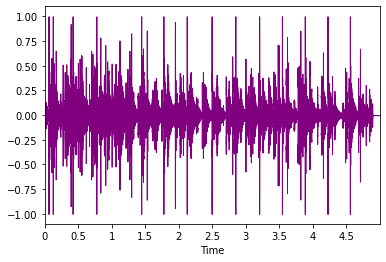

In [10]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [11]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [13]:
result = generate_features(y)

In [14]:
result.shape

(128, 480, 3)

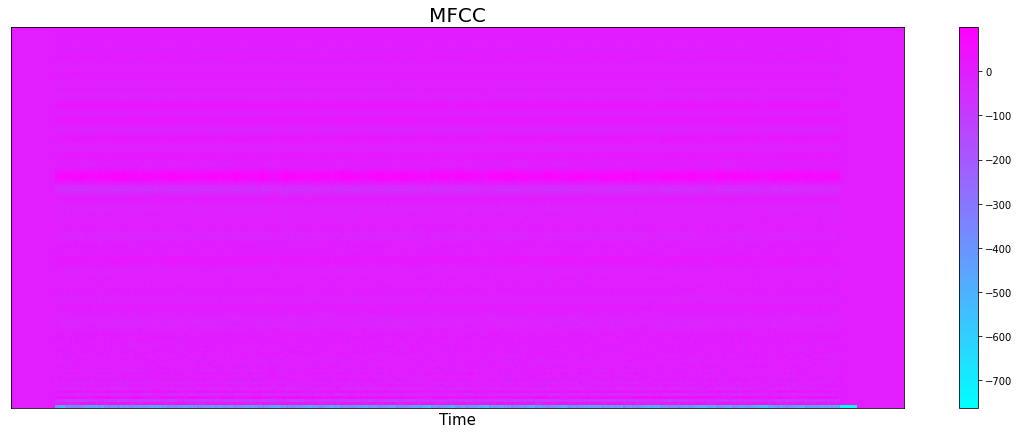

In [15]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

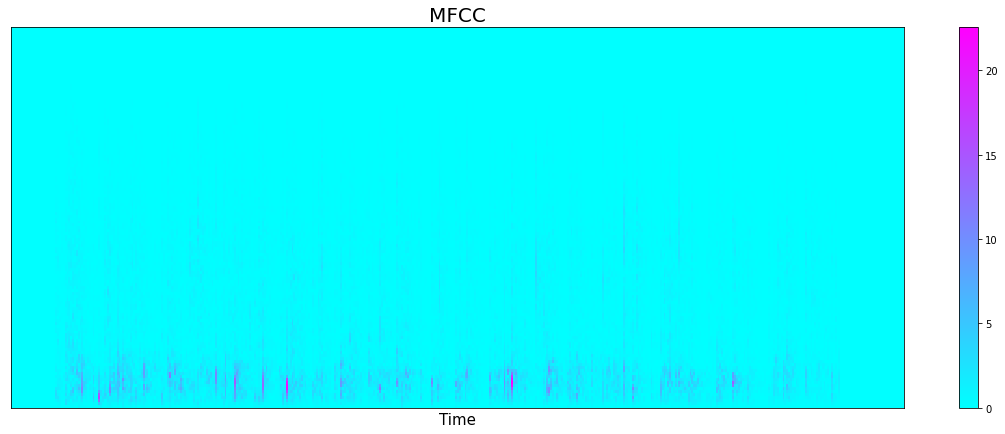

In [16]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

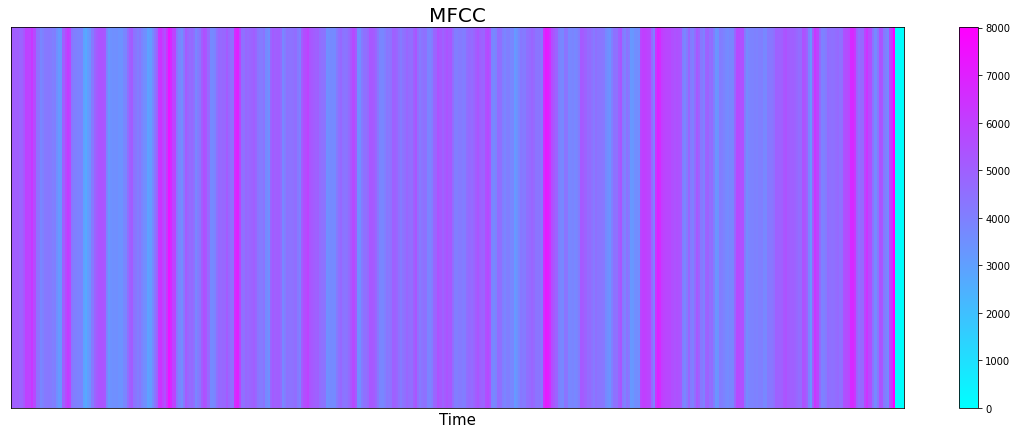

In [17]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

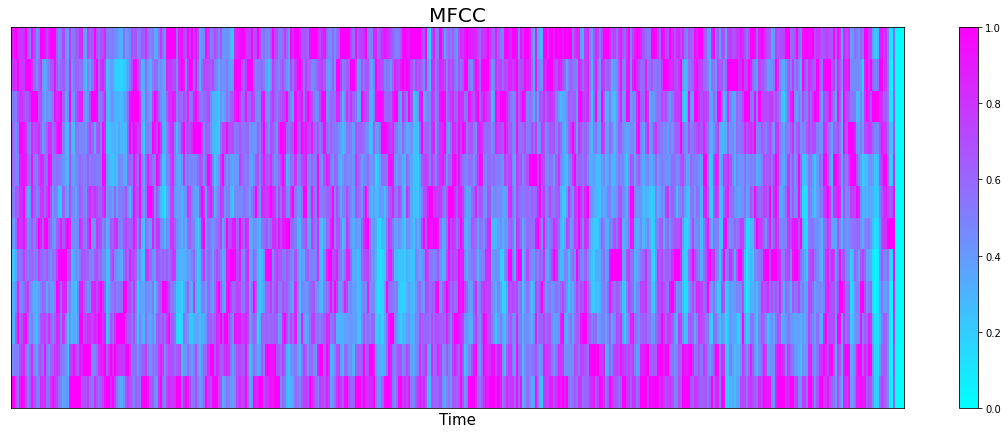

In [18]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

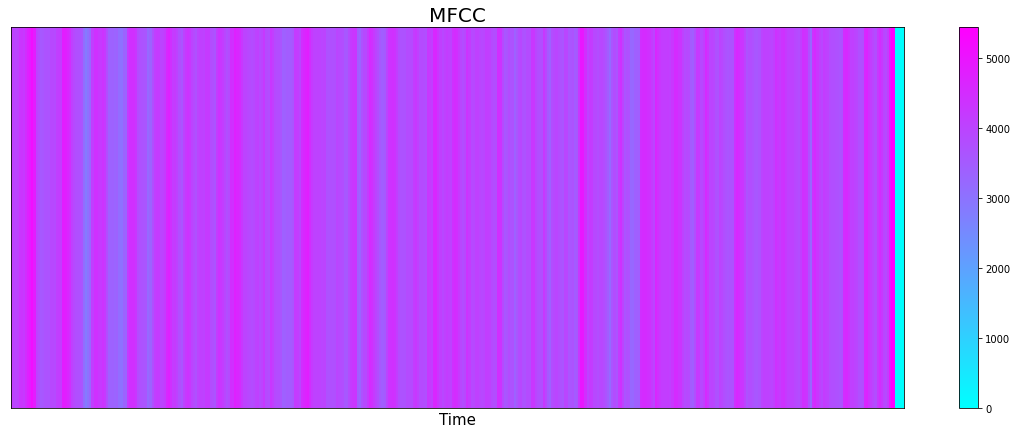

In [19]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [20]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [21]:
X, y = get_features(df, rs=(224,224))

In [22]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [23]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


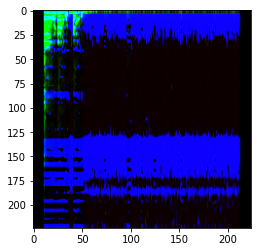

In [24]:
plt.imshow(X[144])

In [25]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [26]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# MODEL

In [27]:
#from tensorflow.keras.applications import VGG19
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Intento 1

In [28]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-adam-ResNet50-0.1.h5")

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 11s 212ms/step - loss: 101.4910 - accuracy: 0.0968 - val_loss: 3949913354427682840391974912.0000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 125ms/step - loss: 12.3935 - accuracy: 0.0986 - val_loss: 49005708238999519232.0000 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 125ms/step - loss: 9.7344 - accuracy: 0.1198 - val_loss: 325098087120896.0000 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 3s 126ms/step - loss: 9.7868 - accuracy: 0.1090 - val_loss: 7603615694848.0000 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 126ms/step - loss: 5.3293 - accuracy: 0.0773 - val_loss: 25747826688.0000 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 126ms/step - loss: 4.7573 - accuracy: 0.0832 - val_loss: 66642452.0000 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 

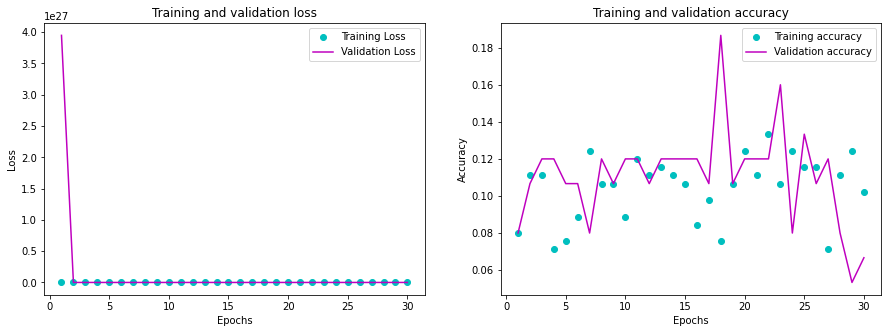

In [31]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [32]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 1s 195ms/step - loss: 44.5381 - accuracy: 0.0700
Confusion_matrix:  tf.Tensor(
[[ 7  0  0  0  0  3  0  0  0  0]
 [ 7  0  0  0  0  3  0  0  0  0]
 [ 1  0  0  0  0  9  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  6  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  3  0  0  0  0]
 [ 6  0  0  0  0  3  0  0  0  1]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [33]:
model.save("model/ResNet50/fit-adam-ResNet50-0.1.h5")

# Intento 2 

In [34]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-adam-ResNet50-0.01.h5")

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 160ms/step - loss: 11.4541 - accuracy: 0.0752 - val_loss: 597347556220993536.0000 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 126ms/step - loss: 2.6774 - accuracy: 0.0955 - val_loss: 15936043008.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 2.3754 - accuracy: 0.1000 - val_loss: 7942658.5000 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 2.3709 - accuracy: 0.1583 - val_loss: 196662.2344 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 2.0966 - accuracy: 0.2737 - val_loss: 15735.8320 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 3s 127ms/step - loss: 2.0730 - accuracy: 0.2458 - val_loss: 3435.3877 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 2.1505 - accuracy: 0.1926 - 

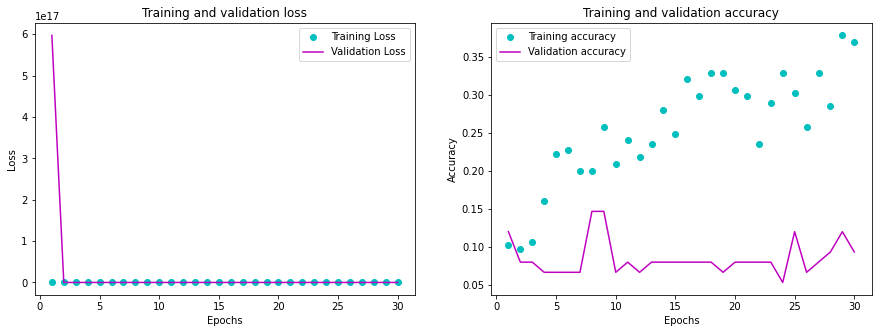

In [37]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [38]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 3.5577 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [39]:
model.save("model/ResNet50/fit-adam-ResNet50-0.01.h5")

# Intento 3 

In [40]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-adam-ResNet50-0.001.h5")

In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [42]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 160ms/step - loss: 3.9691 - accuracy: 0.1165 - val_loss: 27000.8496 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 127ms/step - loss: 2.1453 - accuracy: 0.2136 - val_loss: 971.1619 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 1.9348 - accuracy: 0.3071 - val_loss: 2.3244 - val_accuracy: 0.0667
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 1.6700 - accuracy: 0.4003 - val_loss: 2.2992 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 1.4933 - accuracy: 0.4863 - val_loss: 2.3004 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 127ms/step - loss: 1.2603 - accuracy: 0.6202 - val_loss: 2.3003 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 1.4008 - accuracy: 0.5401 - val_loss: 2.2997 - val_accuracy: 0.1200


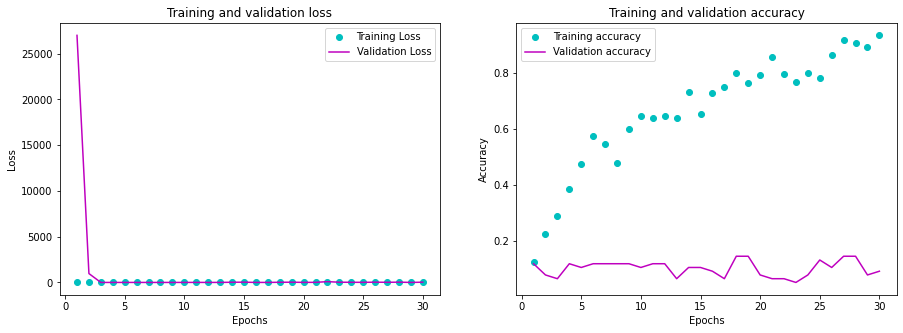

In [43]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [44]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 25.0312 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [45]:
model.save("model/ResNet50/fit-adam-ResNet50-0.001.h5")

# intento 4

In [46]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-adam-ResNet50-0.0001.h5")

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [48]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 159ms/step - loss: 2.0295 - accuracy: 0.3613 - val_loss: 2.4721 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 3s 127ms/step - loss: 0.8259 - accuracy: 0.7662 - val_loss: 2.5797 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 0.5843 - accuracy: 0.8234 - val_loss: 2.7442 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 0.2862 - accuracy: 0.9144 - val_loss: 2.8461 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 0.2531 - accuracy: 0.9105 - val_loss: 2.9815 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 0.2171 - accuracy: 0.9436 - val_loss: 3.0334 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 0.2983 - accuracy: 0.8731 - val_loss: 3.7332 - val_accuracy: 0.0800
Epoch 

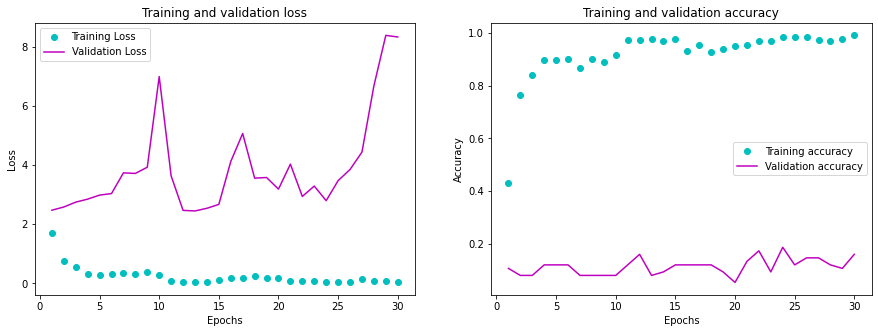

In [49]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [50]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 5.5206 - accuracy: 0.2200
Confusion_matrix:  tf.Tensor(
[[ 0  6  0  4  0  0  0  0  0  0]
 [ 0  6  1  0  0  0  3  0  0  0]
 [ 0  1  7  1  0  0  1  0  0  0]
 [ 0  2  0  8  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  4  1  5  0  0  0  0  0  0]
 [ 0  2  4  3  0  0  1  0  0  0]
 [ 0  1  5  4  0  0  0  0  0  0]
 [ 0  1  0  8  0  0  1  0  0  0]
 [ 0  3  0  6  0  0  1  0  0  0]], shape=(10, 10), dtype=int32)


In [51]:
model.save("model/ResNet50/fit-adam-ResNet50-0.0001.h5")

# intento 5

In [52]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-adam-ResNet50-0.00001.h5")

In [53]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [54]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 159ms/step - loss: 2.5693 - accuracy: 0.1549 - val_loss: 2.6106 - val_accuracy: 0.1467
Epoch 2/30
23/23 [==============================] - 3s 127ms/step - loss: 1.4940 - accuracy: 0.5414 - val_loss: 2.6863 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 0.9515 - accuracy: 0.7823 - val_loss: 2.6643 - val_accuracy: 0.1467
Epoch 4/30
23/23 [==============================] - 3s 128ms/step - loss: 0.6288 - accuracy: 0.8956 - val_loss: 2.5986 - val_accuracy: 0.1467
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 0.4871 - accuracy: 0.9229 - val_loss: 2.4776 - val_accuracy: 0.1467
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 0.3174 - accuracy: 0.9829 - val_loss: 2.8449 - val_accuracy: 0.1333
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 0.3260 - accuracy: 0.9433 - val_loss: 3.2899 - val_accuracy: 0.1200
Epoch 

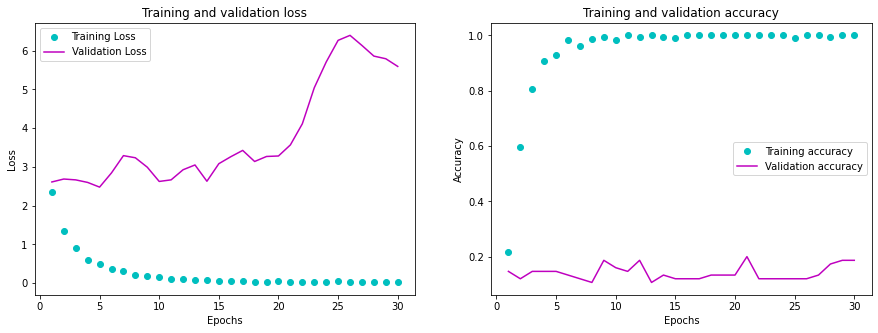

In [55]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [56]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 5.6530 - accuracy: 0.1600
Confusion_matrix:  tf.Tensor(
[[ 6  0  0  4  0  0  0  0  0  0]
 [ 9  0  0  1  0  0  0  0  0  0]
 [ 9  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  9  0  0  0  0  0  0]
 [ 4  0  0  6  0  0  0  0  0  0]
 [ 4  0  0  6  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 3  0  0  7  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [57]:
model.save("model/ResNet50/fit-adam-ResNet50-0.00001.h5")

# cambio de SGD

# INTENTO 1

In [58]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-SGD-ResNet50-0.1.h5")

In [59]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 6s 155ms/step - loss: 6.4476 - accuracy: 0.0908 - val_loss: 1055.4431 - val_accuracy: 0.0667
Epoch 2/30
23/23 [==============================] - 3s 123ms/step - loss: 2.3670 - accuracy: 0.1163 - val_loss: 9.4399 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 123ms/step - loss: 2.2826 - accuracy: 0.1463 - val_loss: 12.2700 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 123ms/step - loss: 2.2160 - accuracy: 0.1683 - val_loss: 2.3770 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 123ms/step - loss: 2.2395 - accuracy: 0.1353 - val_loss: 2.2991 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 124ms/step - loss: 1.9964 - accuracy: 0.2353 - val_loss: 2.3022 - val_accuracy: 0.1600
Epoch 7/30
23/23 [==============================] - 3s 122ms/step - loss: 2.0382 - accuracy: 0.2216 - val_loss: 2.2950 - val_accuracy: 0.1467
Ep

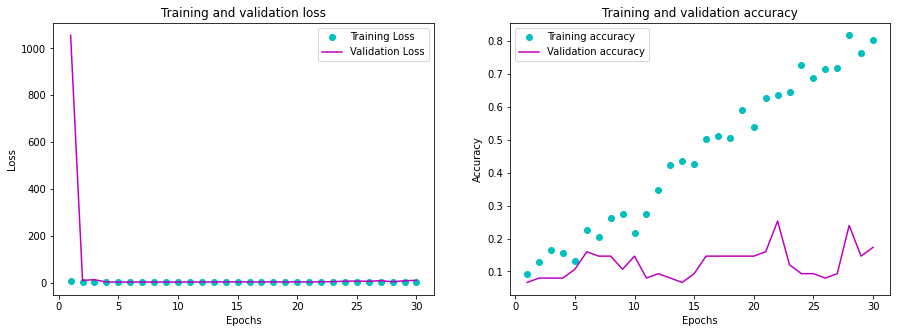

In [61]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [62]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 9.5378 - accuracy: 0.1800
Confusion_matrix:  tf.Tensor(
[[ 0  3  0  0  7  0  0  0  0  0]
 [ 0  8  0  0  2  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  4  0  0  6  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  1  0  0  9  0  0  0  0  0]
 [ 0  2  0  0  8  0  0  0  0  0]
 [ 0  1  0  0  9  0  0  0  0  0]
 [ 0  3  0  0  7  0  0  0  0  0]
 [ 0  3  0  0  7  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [63]:
model.save("model/ResNet50/fit-SGD-ResNet50-0.1.h5")

# INTENTO 2

In [64]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-SGD-ResNet50-0.01.h5")

In [65]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [66]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 6s 157ms/step - loss: 2.5616 - accuracy: 0.2220 - val_loss: 2.9993 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 3s 124ms/step - loss: 1.9403 - accuracy: 0.3350 - val_loss: 3.6650 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 123ms/step - loss: 1.6114 - accuracy: 0.4608 - val_loss: 3.2644 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 123ms/step - loss: 1.2602 - accuracy: 0.5881 - val_loss: 3.4784 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 124ms/step - loss: 0.7740 - accuracy: 0.7389 - val_loss: 3.9478 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 124ms/step - loss: 0.6773 - accuracy: 0.7433 - val_loss: 3.2971 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 3s 122ms/step - loss: 0.3466 - accuracy: 0.8732 - val_loss: 2.9671 - val_accuracy: 0.0800
Epoch 

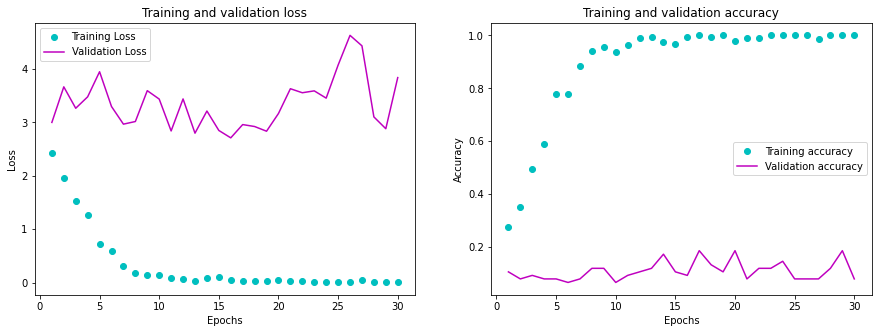

In [67]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [68]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 3.5386 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  2]
 [10  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  3]
 [10  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0  0  9]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [69]:
model.save("model/ResNet50/fit-SGD-ResNet50-0.01.h5")

# INTENTO 3

In [70]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-SGD-ResNet50-0.001.h5")

In [71]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [72]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 6s 156ms/step - loss: 2.2858 - accuracy: 0.1896 - val_loss: 2.9243 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 123ms/step - loss: 1.5879 - accuracy: 0.4858 - val_loss: 2.5576 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 122ms/step - loss: 1.1477 - accuracy: 0.6573 - val_loss: 2.7340 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 123ms/step - loss: 0.9398 - accuracy: 0.7108 - val_loss: 3.0142 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 123ms/step - loss: 0.7212 - accuracy: 0.8609 - val_loss: 3.7982 - val_accuracy: 0.0533
Epoch 6/30
23/23 [==============================] - 3s 122ms/step - loss: 0.5179 - accuracy: 0.9082 - val_loss: 3.7132 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 123ms/step - loss: 0.5244 - accuracy: 0.8925 - val_loss: 4.0024 - val_accuracy: 0.1200
Epoch 

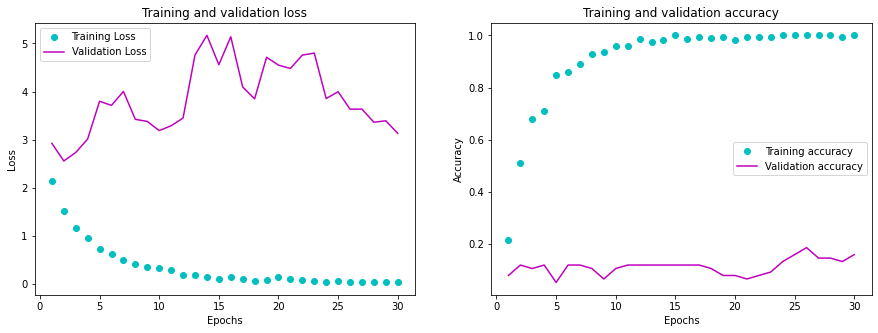

In [73]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [74]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 3.4499 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  2  0  0  1  0  7  0  0]
 [ 0  0  0  1  0  0  0  9  0  0]
 [ 0  0  0  1  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  1  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  1  0  9  0  0]], shape=(10, 10), dtype=int32)


In [75]:
model.save("model/ResNet50/fit-SGD-ResNet50-0.001.h5")

# INTENTO 4

In [76]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-SGD-ResNet50-0.0001.h5")

In [77]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [78]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 6s 155ms/step - loss: 2.6808 - accuracy: 0.0757 - val_loss: 2.7612 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 123ms/step - loss: 2.3557 - accuracy: 0.0975 - val_loss: 2.7392 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 122ms/step - loss: 1.9185 - accuracy: 0.3168 - val_loss: 2.8261 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 122ms/step - loss: 1.7898 - accuracy: 0.4211 - val_loss: 2.7869 - val_accuracy: 0.1333
Epoch 5/30
23/23 [==============================] - 3s 123ms/step - loss: 1.7432 - accuracy: 0.4318 - val_loss: 3.0702 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 123ms/step - loss: 1.5382 - accuracy: 0.5430 - val_loss: 3.2075 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 122ms/step - loss: 1.4397 - accuracy: 0.5803 - val_loss: 3.3452 - val_accuracy: 0.0800
Epoch 

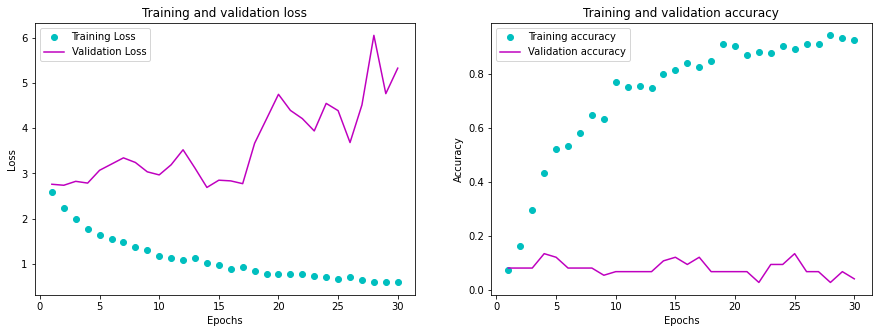

In [79]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [80]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 4.4981 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  9  0  0  0  0  0  1  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  4  6  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  3  0]
 [ 0  2  8  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  2  8  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  1  0]], shape=(10, 10), dtype=int32)


In [81]:
model.save("model/ResNet50/fit-SGD-ResNet50-0.0001.h5")

# INTENTO 5

In [82]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-SGD-ResNet50-0.00001.h5")

In [83]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [84]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 6s 156ms/step - loss: 2.7417 - accuracy: 0.0913 - val_loss: 2.8114 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 123ms/step - loss: 2.7720 - accuracy: 0.0818 - val_loss: 2.7076 - val_accuracy: 0.0667
Epoch 3/30
23/23 [==============================] - 3s 123ms/step - loss: 2.7347 - accuracy: 0.1280 - val_loss: 2.6431 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 123ms/step - loss: 2.5932 - accuracy: 0.1500 - val_loss: 2.6619 - val_accuracy: 0.0400
Epoch 5/30
23/23 [==============================] - 3s 123ms/step - loss: 2.4496 - accuracy: 0.1545 - val_loss: 2.6670 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 3s 123ms/step - loss: 2.5190 - accuracy: 0.1785 - val_loss: 2.5171 - val_accuracy: 0.1467
Epoch 7/30
23/23 [==============================] - 3s 123ms/step - loss: 2.4671 - accuracy: 0.1503 - val_loss: 2.5808 - val_accuracy: 0.1067
Epoch 

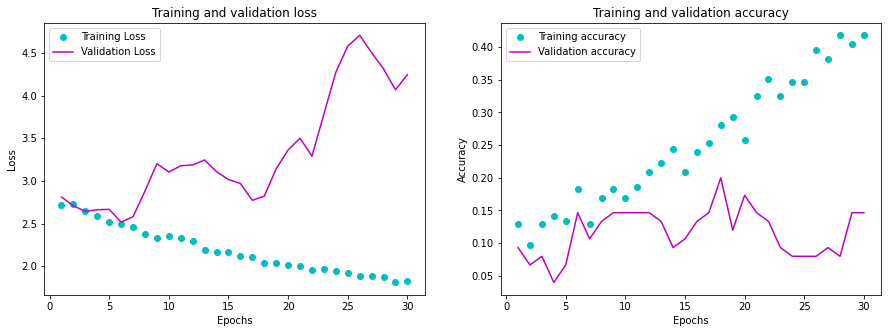

In [85]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [86]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 4.2077 - accuracy: 0.1400
Confusion_matrix:  tf.Tensor(
[[0 0 0 1 0 0 7 0 0 2]
 [0 0 0 1 0 0 9 0 0 0]
 [0 0 0 2 0 0 6 0 0 2]
 [0 0 0 2 0 0 0 0 0 8]
 [0 0 0 2 0 0 6 0 0 2]
 [0 0 0 1 0 0 0 0 0 9]
 [0 0 0 0 0 0 4 0 0 6]
 [0 0 0 1 0 0 2 0 0 7]
 [0 0 0 2 0 0 0 0 0 8]
 [0 0 0 1 0 0 1 0 0 8]], shape=(10, 10), dtype=int32)


In [87]:
model.save("model/ResNet50/fit-SGD-ResNet50-0.00001.h5")

# Cambio a Adamax

# intento 1

In [88]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-Adamax-ResNet50-0.1.h5")

In [89]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [90]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 161ms/step - loss: 84.8164 - accuracy: 0.1094 - val_loss: 1987668091053204723204096.0000 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 128ms/step - loss: 5.7714 - accuracy: 0.0905 - val_loss: 10798132971438080.0000 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 128ms/step - loss: 3.7727 - accuracy: 0.1220 - val_loss: 1200720969728.0000 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 3s 129ms/step - loss: 2.7004 - accuracy: 0.1170 - val_loss: 2628560896.0000 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 128ms/step - loss: 2.6447 - accuracy: 0.1490 - val_loss: 20172528.0000 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 2.4893 - accuracy: 0.2185 - val_loss: 139641.5938 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 129ms/step - loss: 

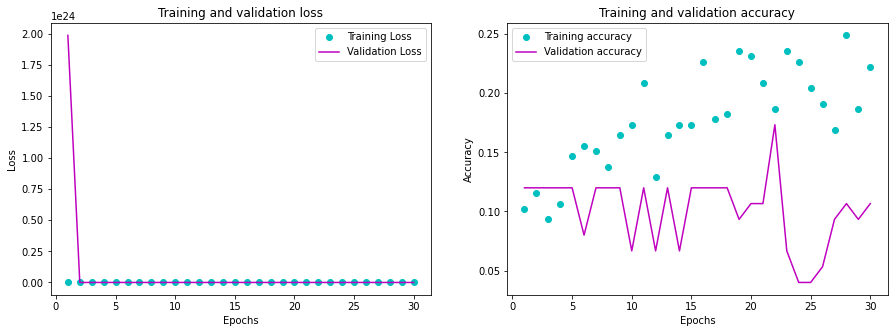

In [91]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [92]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 19.8621 - accuracy: 0.0900
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  7  0  0  3  0]
 [ 1  0  0  0  0  3  0  0  6  0]
 [ 0  2  1  0  0  3  0  0  3  1]
 [ 2  0  0  0  0  7  0  0  0  1]
 [ 0  0  0  0  0  6  0  0  4  0]
 [ 2  0  0  0  0  8  0  0  0  0]
 [ 2  0  0  0  0  3  0  0  5  0]
 [ 0  0  0  0  0  8  0  0  2  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  3  0]], shape=(10, 10), dtype=int32)


In [93]:
model.save("model/ResNet50/fit-Adamax-ResNet50-0.1.h5")

# intento 2

In [94]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-Adamax-ResNet50-0.01.h5")

In [95]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [96]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 160ms/step - loss: 9.4485 - accuracy: 0.1203 - val_loss: 23797995027824640.0000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 129ms/step - loss: 2.5375 - accuracy: 0.1170 - val_loss: 53745602560.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 129ms/step - loss: 2.3246 - accuracy: 0.1061 - val_loss: 23519400.0000 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 128ms/step - loss: 2.3294 - accuracy: 0.1731 - val_loss: 234554.8281 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 3s 128ms/step - loss: 2.1866 - accuracy: 0.2000 - val_loss: 2.2962 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 2.1951 - accuracy: 0.1846 - val_loss: 2.2975 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 128ms/step - loss: 2.1243 - accuracy: 0.2090 - val_loss

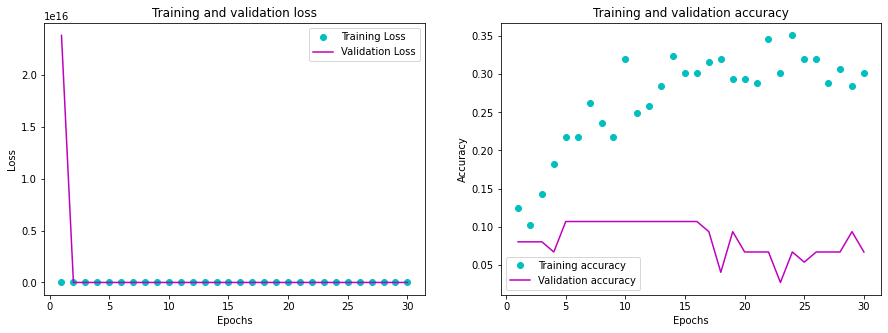

In [97]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [98]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 15.5236 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [99]:
model.save("model/ResNet50/fit-Adamax-ResNet50-0.01.h5")

# intento 3

In [100]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-Adamax-ResNet50-0.001.h5")

In [101]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [102]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 161ms/step - loss: 3.0598 - accuracy: 0.2731 - val_loss: 7.1970 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 127ms/step - loss: 1.9226 - accuracy: 0.3939 - val_loss: 3.1189 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 128ms/step - loss: 1.1169 - accuracy: 0.6395 - val_loss: 2.4124 - val_accuracy: 0.1733
Epoch 4/30
23/23 [==============================] - 3s 128ms/step - loss: 1.0712 - accuracy: 0.7015 - val_loss: 2.3370 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 128ms/step - loss: 0.6692 - accuracy: 0.8059 - val_loss: 2.4016 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 0.5261 - accuracy: 0.8004 - val_loss: 2.6154 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 129ms/step - loss: 0.4541 - accuracy: 0.8341 - val_loss: 2.5462 - val_accuracy: 0.1067
Epoch 

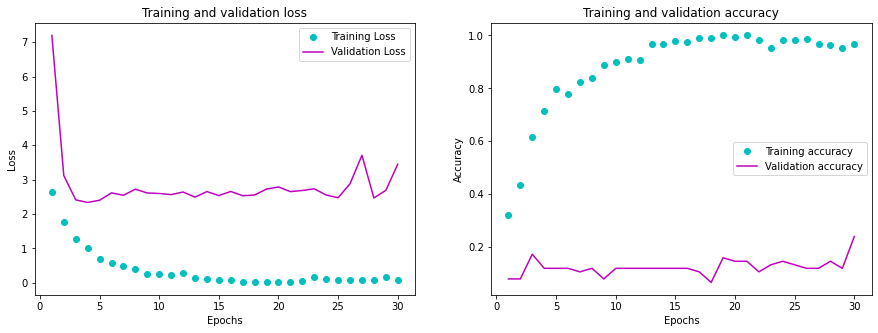

In [103]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [104]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 3.8218 - accuracy: 0.2300
Confusion_matrix:  tf.Tensor(
[[ 0  0  3  0  0  0  7  0  0  0]
 [ 0  8  0  0  0  0  2  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  8  0  0  0]
 [ 0  5  3  0  0  0  2  0  0  0]
 [ 0  0  2  0  0  0  8  0  0  0]
 [ 0  2  3  0  0  0  5  0  0  0]
 [ 0  0  9  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  0  8  0  0  0]
 [ 0  2  0  0  0  0  8  0  0  0]], shape=(10, 10), dtype=int32)


In [105]:
model.save("model/ResNet50/fit-Adamax-ResNet50-0.001.h5")

# intento 4

In [106]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-Adamax-ResNet50-0.0001.h5")

In [107]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [108]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 165ms/step - loss: 2.0347 - accuracy: 0.3081 - val_loss: 2.7185 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 128ms/step - loss: 0.7489 - accuracy: 0.7981 - val_loss: 3.0265 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 0.4459 - accuracy: 0.8538 - val_loss: 2.8394 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 0.2128 - accuracy: 0.9844 - val_loss: 2.8130 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 131ms/step - loss: 0.1559 - accuracy: 0.9623 - val_loss: 3.0503 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 131ms/step - loss: 0.0550 - accuracy: 1.0000 - val_loss: 3.6101 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 129ms/step - loss: 0.0818 - accuracy: 0.9780 - val_loss: 3.8171 - val_accuracy: 0.1200
Epoch 

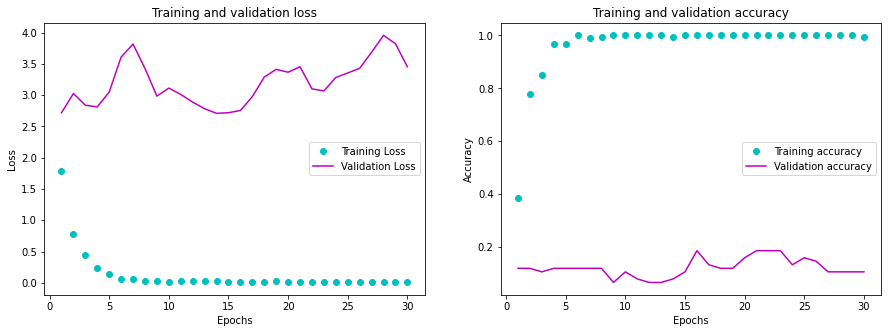

In [109]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [110]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 3.8113 - accuracy: 0.1100
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  2  0  0  8  0  0  0]
 [ 0  0  0  4  0  0  6  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  9  1  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  1  0  0  9  0  0  0]], shape=(10, 10), dtype=int32)


In [111]:
model.save("model/ResNet50/fit-Adamax-ResNet50-0.0001.h5")

# intento 5

In [112]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/ResNet50/base-Adamax-ResNet50-0.00001.h5")

In [113]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [114]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 162ms/step - loss: 2.5195 - accuracy: 0.1687 - val_loss: 2.7165 - val_accuracy: 0.1467
Epoch 2/30
23/23 [==============================] - 3s 129ms/step - loss: 1.7023 - accuracy: 0.4269 - val_loss: 2.7601 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 128ms/step - loss: 1.3914 - accuracy: 0.6168 - val_loss: 2.6320 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 128ms/step - loss: 1.1506 - accuracy: 0.7159 - val_loss: 2.6359 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 129ms/step - loss: 1.0049 - accuracy: 0.8053 - val_loss: 2.6719 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 0.7820 - accuracy: 0.8767 - val_loss: 2.6955 - val_accuracy: 0.2533
Epoch 7/30
23/23 [==============================] - 3s 129ms/step - loss: 0.8774 - accuracy: 0.8303 - val_loss: 3.0743 - val_accuracy: 0.2400
Epoch 

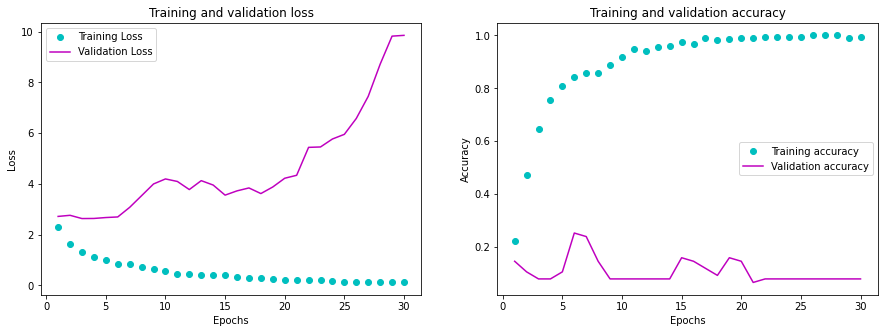

In [115]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [116]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 9.1254 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]], shape=(10, 10), dtype=int32)


In [117]:
model.save("model/ResNet50/fit-Adamax-ResNet50-0.00001.h5")